<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.4 MB/s eta 0:00:00


###Load Libraries

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [4]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [5]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [6]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [7]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

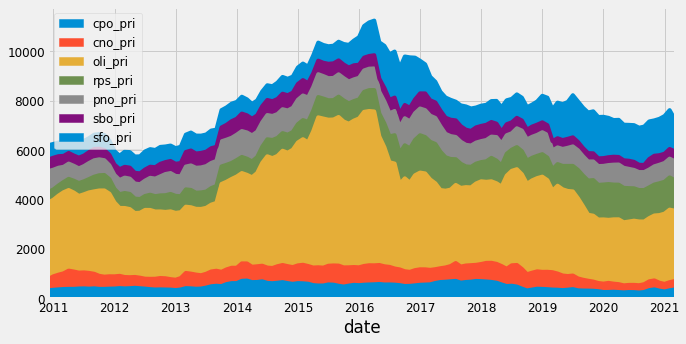

In [8]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [10]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [11]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [12]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [13]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [14]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [15]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [16]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [17]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

In [18]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='tanh'))
cnn_model.add(tf.keras.layers.Dense(1, 'linear'))

# compile model using adam
cnn_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = cnn_model.fit(X_train, y_train, epochs=300, batch_size = 128, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
cnn_model.evaluate(X_test, y_test)


#cnn_model.compile(loss='mse', optimizer='adam')
#cnn_model.summary()
#bst -> epochs = 300, batch_size = 128, RMSE = 32
#bst -> epochs = 350, batch_size = 100, RMSE = 36
#bst -> epochs = 400, batch_size = 128, RMSE = 39

Epoch 1/300
1/1 [==============================] - 8s 8s/step - loss: 0.4581 - mse: 0.4581 - val_loss: 0.6216 - val_mse: 0.6216
Epoch 2/300
1/1 [==============================] - 0s 34ms/step - loss: 0.2858 - mse: 0.2858 - val_loss: 0.4097 - val_mse: 0.4097
Epoch 3/300
1/1 [==============================] - 0s 29ms/step - loss: 0.1590 - mse: 0.1590 - val_loss: 0.2525 - val_mse: 0.2525
Epoch 4/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0762 - mse: 0.0762 - val_loss: 0.1470 - val_mse: 0.1470
Epoch 5/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0872 - val_mse: 0.0872
Epoch 6/300
1/1 [==============================] - 0s 27ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 7/300
1/1 [==============================] - 0s 29ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0601 - val_mse: 0.0601
Epoch 8/300
1/1 [==============================] - 0s 27ms/step - loss: 0.0618 - mse: 0.0618

[0.01877521350979805, 0.01877521350979805]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


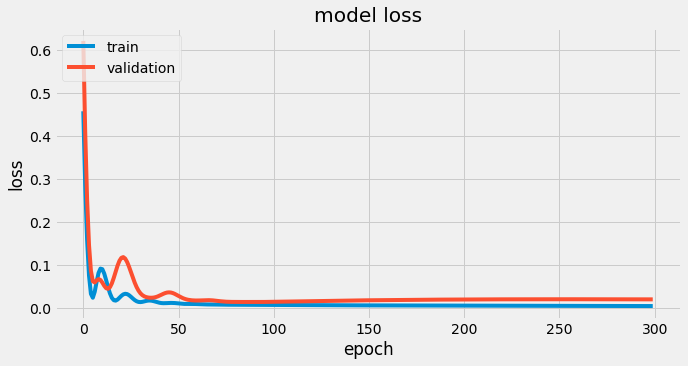

In [19]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
mse_cnn = cnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 21ms/step - loss: 0.0188 - mse: 0.0188


####Baseline MSE = 0.0188

In [47]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             960       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
______________________________________________________

###Predict the Test without Hyperparameter Tuning

In [48]:
y_pred = cnn_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 17ms/step


array([[ 0.10916676],
       [ 0.09319507],
       [ 0.16884238],
       [ 0.14781769],
       [ 0.07189663],
       [ 0.07150551],
       [ 0.07168821],
       [ 0.06214303],
       [-0.00213088],
       [-0.03077103],
       [-0.03607072],
       [ 0.00858726],
       [-0.02474773],
       [-0.02574362],
       [-0.01997059],
       [-0.0437952 ],
       [-0.06112751],
       [ 0.05929474],
       [ 0.13917696],
       [ 0.11374111],
       [ 0.04029406],
       [ 0.05299819]], dtype=float32)

In [49]:
y_pred.reshape(1,-1)

array([[ 0.10916676,  0.09319507,  0.16884238,  0.14781769,  0.07189663,
         0.07150551,  0.07168821,  0.06214303, -0.00213088, -0.03077103,
        -0.03607072,  0.00858726, -0.02474773, -0.02574362, -0.01997059,
        -0.0437952 , -0.06112751,  0.05929474,  0.13917696,  0.11374111,
         0.04029406,  0.05299819]], dtype=float32)

###Invert Transformed Data

In [50]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[362.6667  356.27805 386.53696 378.12708 347.75864 347.6022  347.67526
  343.8572  318.14764 306.6916  304.57172 322.4349  309.10092 308.70258
  311.01178 301.4819  294.54898 342.7179  374.67078 364.49646 335.1176
  340.19928]]


###Plot History, Actual and Predicted Value

In [51]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [52]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [53]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([362.6667 , 356.27805, 386.53696, 378.12708, 347.75864, 347.6022 ,
       347.67526, 343.8572 , 318.14764, 306.6916 , 304.57172, 322.4349 ,
       309.10092, 308.70258, 311.01178, 301.4819 , 294.54898, 342.7179 ,
       374.67078, 364.49646, 335.1176 , 340.19928], dtype=float32)

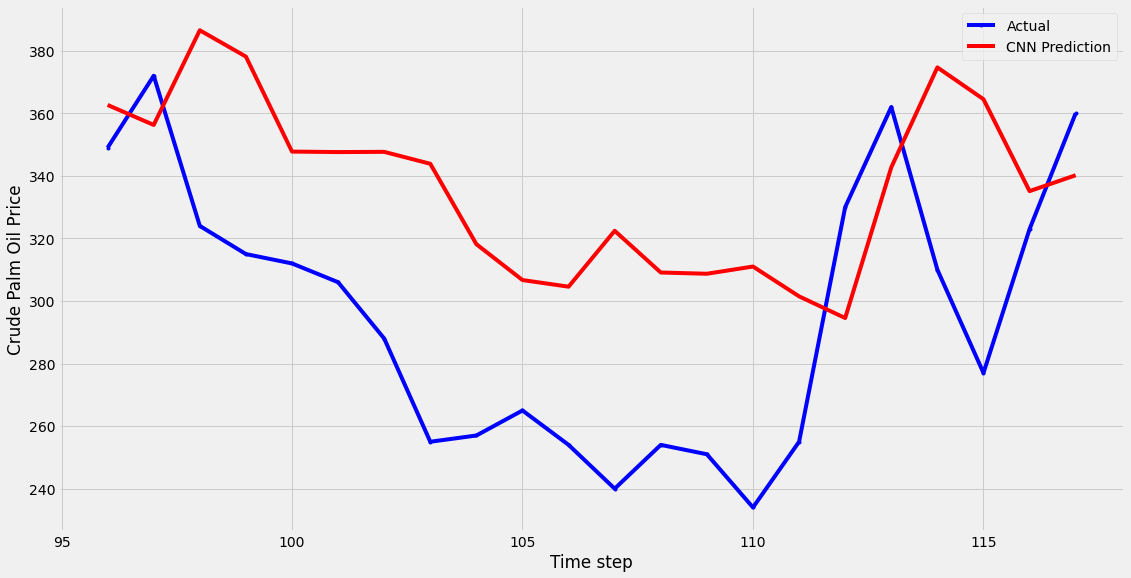

In [54]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
#plt.grid()
#plt.show();

###Evaluate CNN Model Accuracy

In [29]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

#EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 49.63216885653409
MDA value of the CNN Model is: 0.42857142857142855
MAPE value of the CNN Model is: 17.97646217513856
RMSE value of the CNN Model is: 54.8090716586132
MSE value of the CNN Model is: 3004.0343360789966


###Tuning CNN with Keras Tuner

In [30]:
class ANNhypermodel(HyperModel):
#class CNNHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        
        
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)

        model.add(keras.layers.Dense(units=hp_units_1, activation='tanh', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        model.add(keras.layers.Dense(1))

        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        #model.add(
            #layers.Dense(
                #hp.Float(
                    #'batch_size',
                    #'type": "range', ###########
                     #min_value= 10, 
                     #max_value=60,
                     #default=1,
                     #step=20)
                    #'value_type': "int" ###########
            #)
        #)
       #---------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
#hypermodel = CNNHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [ ]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [ ]:
tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [ ]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 343ms/step - loss: 0.1068 - mae: 0.3057 - mse: 0.1068


####Random Search MSE = 0.1198

In [ ]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 96,
 'units_3': 48,
 'dropout': 0.1,
 'learning_rate': 0.0038287047044982298}

###Build Bayesian Optimization

In [ ]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [ ]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 300ms/step - loss: 0.2367 - mae: 0.4740 - mse: 0.2367


###Bayesian Optimization Search MSE = 0.3479

###Evaluate Bayesian Optimization

In [ ]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 128,
 'units_3': 64,
 'dropout': 0.0,
 'learning_rate': 0.01}

In [ ]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 301ms/step - loss: 0.2367 - mae: 0.4740 - mse: 0.2367


###Build HYPERBAND optimization

In [ ]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [ ]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [ ]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


789.8020212650299  secs


In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
drop out is {best_hps.get('dropout')}
#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')

'''
print(best_hps.get('units'))
print(best_hps.get('layers'))
print(best_hps.get('window'))
print(best_hps.get('learning_rate'))
'''


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128,
second layer is 96 
third layer is 48 
drop out is 0.45
#learning rate is 0.007588827342097074                                        

and the optimal learning rate for the optimizer
is 0.007588827342097074.

[]
1/1 [==============================] - 0s 319ms/step - loss: 0.0114 - mae: 0.0948 - mse: 0.0114
loss:0.01140345074236393 mae: 0.09478043019771576 mse: 0.01140345074236393


"\nprint(best_hps.get('units'))\nprint(best_hps.get('layers'))\nprint(best_hps.get('window'))\nprint(best_hps.get('learning_rate'))\n"

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 128, 'units_2': 96, 'units_3': 48, 'dropout': 0.45, 'learning_rate': 0.007588827342097074, 'tuner/epochs': 150, 'tuner/initial_epoch': 50, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0239'}


###Apply the trained parameters to the CNN

In [31]:
TUcnn_model = tf.keras.Sequential()
TUcnn_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
TUcnn_model.add(tf.keras.layers.Dense(96, activation='tanh'))
TUcnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
TUcnn_model.add(tf.keras.layers.Flatten())

##Hidden Layer
TUcnn_model.add(tf.keras.layers.Dense(48))
#TUcnn_model.add(layers.Dropout(0.45))

#Output layer of model
TUcnn_model.add(tf.keras.layers.Dense(1))

In [32]:
TUcnn_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Adam(learning_rate=0.003021691068008031), metrics= ['mae', 'mse'])
#TUcnn_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),
history = TUcnn_model.fit(X_train, y_train, epochs=40, batch_size=32,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/40
3/3 [==============================] - 1s 129ms/step - loss: 0.5724 - mae: 0.5240 - mse: 0.5724 - val_loss: 0.6396 - val_mae: 0.6992 - val_mse: 0.6396
Epoch 2/40
3/3 [==============================] - 0s 15ms/step - loss: 0.8744 - mae: 0.7971 - mse: 0.8744 - val_loss: 0.1413 - val_mae: 0.3263 - val_mse: 0.1413
Epoch 3/40
3/3 [==============================] - 0s 15ms/step - loss: 0.1044 - mae: 0.2021 - mse: 0.1044 - val_loss: 0.2256 - val_mae: 0.4292 - val_mse: 0.2256
Epoch 4/40
3/3 [==============================] - 0s 15ms/step - loss: 0.1606 - mae: 0.3602 - mse: 0.1606 - val_loss: 0.0548 - val_mae: 0.1959 - val_mse: 0.0548
Epoch 5/40
3/3 [==============================] - 0s 15ms/step - loss: 0.0333 - mae: 0.1461 - mse: 0.0333 - val_loss: 0.1430 - val_mae: 0.3146 - val_mse: 0.1430
Epoch 6/40
3/3 [==============================] - 0s 17ms/step - loss: 0.1103 - mae: 0.2785 - mse: 0.1103 - val_loss: 0.1743 - val_mae: 0.3538 - val_mse: 0.1743
Epoch 7/40
3/3 [=================

<Figure size 720x360 with 0 Axes>

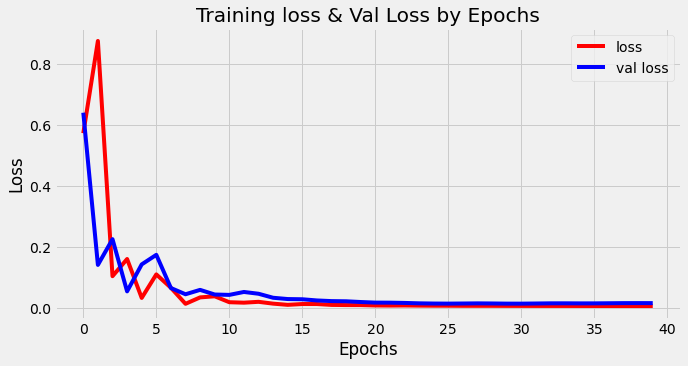

<Figure size 720x360 with 0 Axes>

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

In [34]:
y_predTU = TUcnn_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 95ms/step


array([[ 0.06304727],
       [ 0.05646173],
       [ 0.08723623],
       [ 0.09084903],
       [ 0.05768557],
       [ 0.04078356],
       [ 0.03679685],
       [ 0.02731723],
       [-0.02310941],
       [-0.06864951],
       [-0.0581902 ],
       [-0.04341658],
       [-0.05921231],
       [-0.07559779],
       [-0.06976724],
       [-0.08193035],
       [-0.11407062],
       [-0.07414295],
       [ 0.04713896],
       [ 0.11598832],
       [ 0.05764818],
       [ 0.025331  ]], dtype=float32)

In [35]:
y_predTU.reshape(1,-1)

array([[ 0.06304727,  0.05646173,  0.08723623,  0.09084903,  0.05768557,
         0.04078356,  0.03679685,  0.02731723, -0.02310941, -0.06864951,
        -0.0581902 , -0.04341658, -0.05921231, -0.07559779, -0.06976724,
        -0.08193035, -0.11407062, -0.07414295,  0.04713896,  0.11598832,
         0.05764818,  0.025331  ]], dtype=float32)

###Invert Transformed Tuned Data

In [36]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[344.2189  341.5847  353.8945  355.33963 342.07422 335.31342 333.71872
  329.9269  309.75623 291.5402  295.7239  301.63336 295.31506 288.76086
  291.0931  286.22787 273.37173 289.34283 337.8556  365.39532 342.05927
  329.1324 ]]


In [37]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [38]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [39]:
TU_CNN_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_CNN_Pred
TU_CNN_Pred

array([344.2189 , 341.5847 , 353.8945 , 355.33963, 342.07422, 335.31342,
       333.71872, 329.9269 , 309.75623, 291.5402 , 295.7239 , 301.63336,
       295.31506, 288.76086, 291.0931 , 286.22787, 273.37173, 289.34283,
       337.8556 , 365.39532, 342.05927, 329.1324 ], dtype=float32)

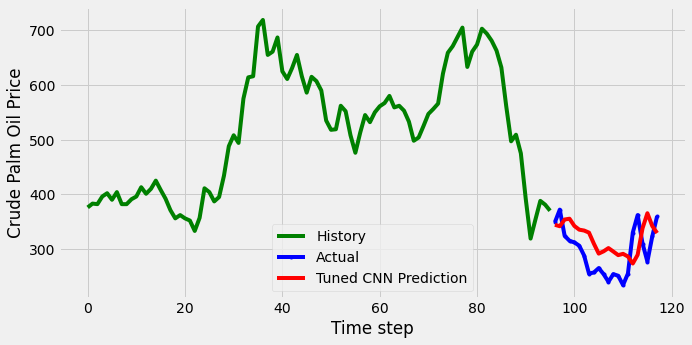

In [44]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_CNN_Pred, color='red', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

In [41]:
TUMAE_cnn = mean_absolute_error(y_test_inv, TU_CNN_Pred)
print('MAE value of the CNN Model is:', TUMAE_cnn)

TUMDA_cnn = mda(y_test_inv, TU_CNN_Pred)
print('MDA value of the CNN Model is:', TUMDA_cnn)

TUMAPE_cnn = mean_absolute_percentage_error(y_test_inv, TU_CNN_Pred)
print('MAPE value of the CNN Model is:', TUMAPE_cnn)

TURMSE_cnn = mean_squared_error(y_test_inv,TU_CNN_Pred, squared=False)
print('RMSE value of the CNN Model is:', TURMSE_cnn)

TUMSE_cnn = mean_squared_error(y_test_inv,TU_CNN_Pred)
print('MSE value of the CNN Model is:', TUMSE_cnn)

MAE value of the CNN Model is: 42.317165027965196
MDA value of the CNN Model is: 0.2857142857142857
MAPE value of the CNN Model is: 14.966546716203469
RMSE value of the CNN Model is: 46.57507600962811
MSE value of the CNN Model is: 2169.237705302636


Tuned CNN Actual VS Predicted Zoomed-IN

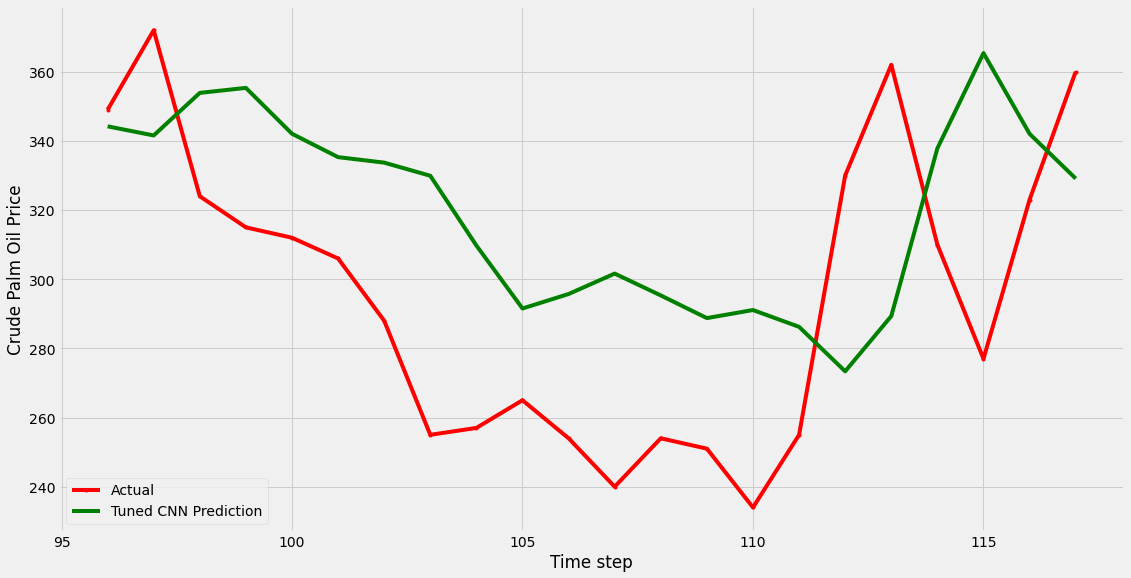

In [63]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_CNN_Pred, color='green', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
#plt.grid()
#plt.show();

##Results

Baseline MSE         = 0.0188

Random search MSE    = 0.1198

Bayesian search MSE  = 0.3479

Hyperband search MSE = 0.0114

Baseline RSME        = 54.80

Tuned CNN RSME       = 46.57

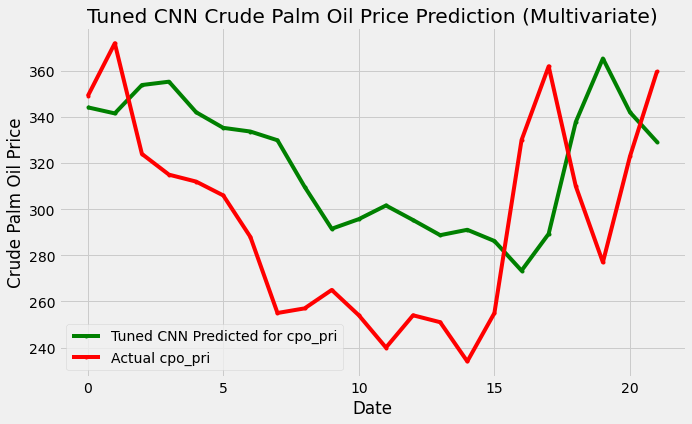

<Figure size 720x360 with 0 Axes>

In [67]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))  
plt.plot(TU_CNN_Pred, color= 'green',marker='.',label = 'Tuned CNN Predicted for cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Tuned CNN Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_cnn.png')

In [73]:
dataframe1=pd.DataFrame(y_test_inv, columns=['Actual']) 
print (dataframe1)

    Actual
0    349.0
1    372.0
2    324.0
3    315.0
4    312.0
5    306.0
6    288.0
7    255.0
8    257.0
9    265.0
10   254.0
11   240.0
12   254.0
13   251.0
14   234.0
15   255.0
16   330.0
17   362.0
18   310.0
19   277.0
20   323.0
21   360.0


In [70]:
dataframe2=pd.DataFrame(TU_CNN_Pred, columns=['TU_CNN_Pred']) 
print (dataframe2)

    TU_CNN_Pred
0    344.218903
1    341.584686
2    353.894501
3    355.339630
4    342.074219
5    335.313416
6    333.718719
7    329.926910
8    309.756226
9    291.540192
10   295.723907
11   301.633362
12   295.315063
13   288.760864
14   291.093109
15   286.227875
16   273.371735
17   289.342834
18   337.855591
19   365.395325
20   342.059265
21   329.132385


In [74]:
 df.to_csv('actual.csv', index=False)